In [17]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#데이터 전처리

In [7]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [47]:
image_dir = "/content/drive/MyDrive/AI/brain_tumor_dataset"
augmented_data_path ='/content/drive/MyDrive/AI/brain_tumor_dataset'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'/yes',n_generated_samples=6, save_to_dir=augmented_data_path+'/yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'/no', n_generated_samples=9, save_to_dir=augmented_data_path+'/no')

In [20]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

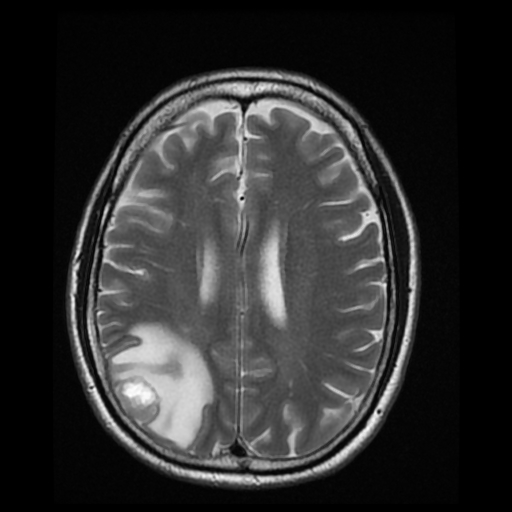

In [44]:
import cv2
from google.colab.patches import cv2_imshow

image1 = cv2.imread('/content/drive/MyDrive/AI/brain_tumor_dataset/yes/Y107.jpg', cv2.IMREAD_COLOR)

cv2_imshow(image1)

In [45]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [48]:
augmented_yes =augmented_data_path+'/yes'
augmented_no = augmented_data_path+'/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2314
X shape is: (2314, 240, 240, 3)
y shape is: (2314, 1)


#VGG 학습

In [49]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [50]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [51]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1619
number of validation examples = 348
number of test examples = 347


In [52]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
IMG_WIDTH, IMG_HEIGHT = (240, 240)
input_shape = (240, 240, 3)

base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

80134624/80134624 [==============================] - 5s 0us/step


In [53]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = model_vgg19
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [54]:
model_vgg19.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
51/51 [==============================] - 31s 347ms/step - loss: 2.7792 - acc: 0.7245 - val_loss: 0.4619 - val_acc: 0.8879
Epoch 2/10
51/51 [==============================] - 10s 191ms/step - loss: 0.2646 - acc: 0.9234 - val_loss: 0.2042 - val_acc: 0.9454
Epoch 3/10
51/51 [==============================] - 10s 192ms/step - loss: 0.0421 - acc: 0.9796 - val_loss: 0.1865 - val_acc: 0.9569
Epoch 4/10
51/51 [==============================] - 10s 195ms/step - loss: 0.0238 - acc: 0.9926 - val_loss: 0.1372 - val_acc: 0.9684
Epoch 5/10
51/51 [==============================] - 10s 196ms/step - loss: 0.0081 - acc: 0.9994 - val_loss: 0.1199 - val_acc: 0.9684
Epoch 6/10
51/51 [==============================] - 10s 197ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.1131 - val_acc: 0.9741
Epoch 7/10
51/51 [==============================] - 10s 197ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.1041 - val_acc: 0.9741
Epoch 8/10
51/51 [==============================] - 10s 197ms/step - 

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_true, y_pred):
    precision, recall2, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(recall2, precision, 'b-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.show()

In [70]:
y_pred = model.predict(X_val)

11/11 [==============================] - 2s 161ms/step


In [71]:
from sklearn.metrics import precision_recall_curve, auc

# assume that y_true and y_scores are the true labels and predicted scores
# for a binary classification problem

precision, recall, _ = precision_recall_curve(y_val, y_pred)
pr_auc = auc(recall, precision)

print("Area under the PR curve: {:.3f}".format(pr_auc))

Area under the PR curve: 0.994


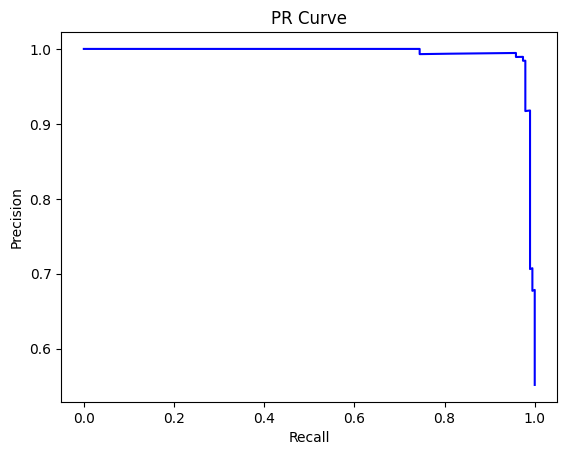

In [72]:
plot_pr_curve(y_val, y_pred)